In [1]:
import tensor_comprehensions as tc
import torch
import tc_composer
from torch.autograd import Variable
from torch.nn import Conv2d
from tc_composer.func.conv import Convolution

[INFO] tc_composer.settings - Setting default tensor type: torch.cuda.FloatTensor
[INFO] tc_composer.settings - Setting epsilon: 1e-16
[INFO] tc_composer.settings - Input tensor shape checking: False
[INFO] tc_composer.settings - Saving compiled options in: /home/ubuntu/tc_composer/options


# Conv with stride/padding

In [2]:
in_channels = 3
out_channels = 64
kernel_size = (11, 11)
padding=(2, 2)
stride=(4, 4)
groups = 1

batch_size = 2
in_height = 128
in_width = 128

In [3]:
tc_image = torch.randn(batch_size, in_channels, in_height, in_width)
tc_conv = Convolution(in_channels=3, out_channels=64, kernel_size=kernel_size, padding=padding, stride=stride, groups=groups)

In [4]:
print(tc_conv.tc_def(tc_image))

def Convolution(
    float(2, 3, 128, 128) input,
    float(64, 3, 11, 11) weight,
    float(64) bias
) -> (
    float(2, 64, 31, 31) output
)
{
    output(n, m, h, w) +=! ((4*h + kh - 2) * (127 - (4*h + kh - 2)) >= 0) && ((4*w + kw - 2) * (127 - (4*w + kw - 2)) >= 0) ?
        input(n, c, 4*h + kh - 2, 4*w + kw - 2) * weight(m, c, kh, kw) : 0.0
            where kh in 0:11, kw in 0:11, h in 0:31, w in 0:31
    output(n, m, h, w) = output(n, m, h, w) + bias(m)
}


# Tuning

In [5]:
option = tc_conv.tune_options(inputs=[tc_image], tuner_config=tc.TunerConfig().pop_size(150).generations(7).mutation_rate(8).number_elites(30).crossover_rate(30))

[INFO] Convolution - Loading start options from file - /home/ubuntu/tc_composer/options/Convolution_Tesla_V100-SXM2-16GB
[INFO] Convolution - Option loaded from file for input shape - [(2, 3, 128, 128)].
[INFO] Convolution - Appending results to /home/ubuntu/tc_composer/options/Convolution_Tesla_V100-SXM2-16GB


In [6]:
option = tc_conv.tune_options(inputs=[tc_image], tuner_config=tc.TunerConfig().pop_size(150).generations(7).mutation_rate(7).number_elites(30))

[INFO] Convolution - Loading start options from file - /home/ubuntu/tc_composer/options/Convolution_Tesla_V100-SXM2-16GB
[INFO] Convolution - Option loaded from file for input shape - [(2, 3, 128, 128)].
[INFO] Convolution - Appending results to /home/ubuntu/tc_composer/options/Convolution_Tesla_V100-SXM2-16GB


In [7]:
print(option)

generic_mapping_options {
  outer_schedule_options {
    fusion_strategy: Max
    allow_skewing: false
    positive_orthant: true
  }
  intra_tile_schedule_options {
    fusion_strategy: Preserve3Coincident
    allow_skewing: false
    positive_orthant: true
  }
  fix_parameters_before_scheduling: false
  tiling {
    sizes: 32
    sizes: 1
    sizes: 1
    sizes: 128
    sizes: 32
  }
  unroll: 32
  tile_imperfectly_nested: false
  match_library_calls: true
}
block {
  x: 256
  y: 2
  z: 1
}
grid {
  x: 1
  y: 256
  z: 64
}
use_shared_memory: false
use_private_memory: true
unroll_copy_shared: false
use_readonly_cache: false
private_depth: 4
shared_depth: 5



In [8]:
tc_conv.recompile(tc_image, option=option)

[INFO] Convolution - Compiling for input shape - [(2, 3, 128, 128)].


# Correctness

In [9]:
torch_conv = Conv2d(in_channels*groups, out_channels*groups, kernel_size, padding=padding, stride=stride, groups=groups)

for p0, p1 in zip(torch_conv.parameters(), tc_conv.params):
    p0.data = p1.data

In [10]:
import numpy as np

np.testing.assert_allclose(tc_conv(tc_image).data, torch_conv(tc_image).data, rtol=1e-4, atol=1e-4)

# Benchmark

In [19]:
import time
from matplotlib import pyplot as plt
import matplotlib
matplotlib.interactive(False)


def mytime(iters, runFun, *args):
    synchronize = torch.cuda.synchronize
    
    timesCPU = []
    timesCPUAndGPU = []
    for i in range(iters):
        synchronize()
        start = time.perf_counter()
        runFun(*args)
        timesCPU.append(time.perf_counter() - start)
        synchronize()
        timesCPUAndGPU.append(time.perf_counter() - start)
    
    timesCPU = sorted(timesCPU)
    
    timesCPUAndGPU = sorted(timesCPUAndGPU)
    
    print("CPU:\t\tmin {}us,\tp50 {}us,\tp90 {}us,\tmax {}us".format(
        int(timesCPU[0] * 1e6),
        int(timesCPU[int(len(timesCPU) // 2)] * 1e6),
        int(timesCPU[int((len(timesCPU) * 9) // 10)] * 1e6),
        int(timesCPU[len(timesCPU) - 1] * 1e6),
    ))
    print("CPU + GPU:\tmin {}us,\tp50 {}us,\tp90 {}us,\tmax {}us".format(
        int(timesCPUAndGPU[0] * 1e6),
        int(timesCPUAndGPU[int(len(timesCPUAndGPU) // 2)] * 1e6),
        int(timesCPUAndGPU[int((len(timesCPUAndGPU) * 9) // 10)] * 1e6),
        int(timesCPUAndGPU[len(timesCPUAndGPU) - 1] * 1e6),
    ))
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(timesCPU[:-len(timesCPU)//200], label='CPU', bins='fd')
    ax.hist(timesCPUAndGPU[:-len(timesCPUAndGPU)//200], label='CPU&GPU', bins='fd')
    ax.legend(loc='upper right')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('seconds')
    ax.set_ylabel('frequency')
    fig.show()
        

CPU:		min 123us,	p50 125us,	p90 127us,	max 548us
CPU + GPU:	min 187us,	p50 189us,	p90 192us,	max 616us


/home/ubuntu/anaconda3/envs/tc/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


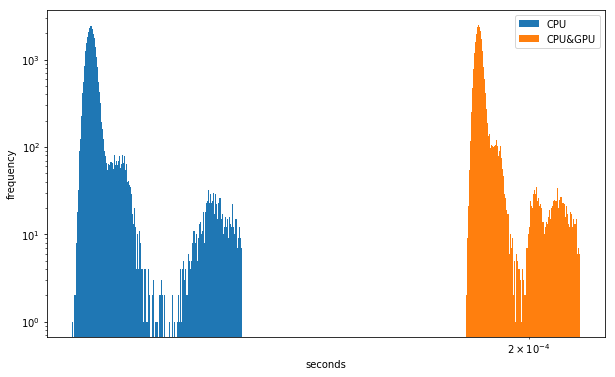

In [23]:
mytime(100000, lambda: tc_conv(torch.randn(batch_size, in_channels, in_height, in_width)))

CPU:		min 81us,	p50 83us,	p90 84us,	max 494us
CPU + GPU:	min 119us,	p50 121us,	p90 123us,	max 509us


/home/ubuntu/anaconda3/envs/tc/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


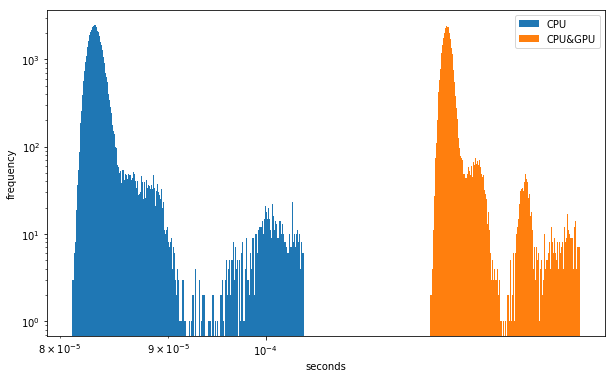

In [24]:
mytime(100000, lambda: torch_conv.forward(torch.randn(batch_size, in_channels, in_height, in_width)))